In [29]:
import torch
from matplotlib.pyplot import xlabel, yscale, xscale
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random

In [30]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)

In [31]:
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))

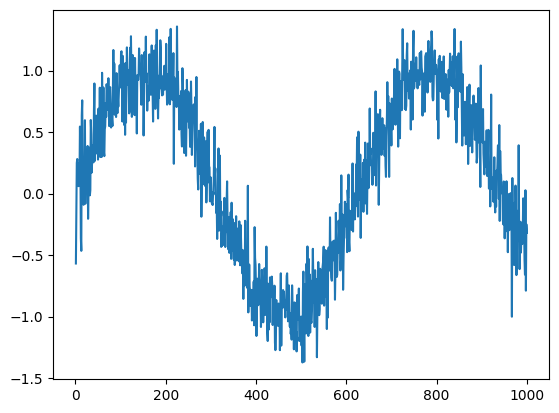

In [32]:
plt.plot(time, x)

In [33]:
tau=4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T-tau+i]
labels=x[tau:].reshape(-1,1)


batch_size=16
n_train=600

In [34]:
def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential=nn.Sequential(
            nn.Linear(4, 10)
            ,nn.ReLU()
            ,nn.Linear(10, 1))
        self.sequential.apply(init_weights)
    def forward(self,x):
        return self.sequential(x)

In [35]:
class TimeDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data            # 数据路径或数据本身
        self.labels = labels         # 标签
        self.transform = transform  # 数据预处理（如transforms.Compose）

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [36]:
data=TimeDataset(features[:600], labels[:600])
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
loss=nn.MSELoss(reduction='none')

In [37]:
def train(model, train_iter, loss, epoch, lr):
    trainer=torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epoch):
        for x,y in train_iter:
            trainer.zero_grad()
            y_hat=model(x)
            l=loss(y_hat, y)
            l.sum().backward()
            trainer.step()
        
        loss_eval=0
        for x,y in train_iter:
            loss_eval+=loss(model(x), y).sum()
        
        print(f'epoch {epoch + 1}, '
              f'loss: {loss_eval})')
    

In [38]:
net=Net()

In [39]:
train(net,dataloader,loss,5,lr=0.01)

epoch 1, loss: 40.46745681762695)
epoch 2, loss: 35.5834846496582)
epoch 3, loss: 33.34917068481445)
epoch 4, loss: 34.82548141479492)
epoch 5, loss: 32.889617919921875)


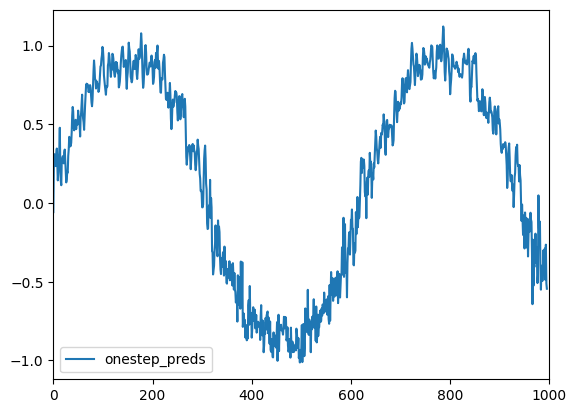

In [40]:
plt.plot(net(features).detach().numpy())
plt.legend(['onestep_preds'])
plt.xlim([0,1000])
plt.show()

In [41]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

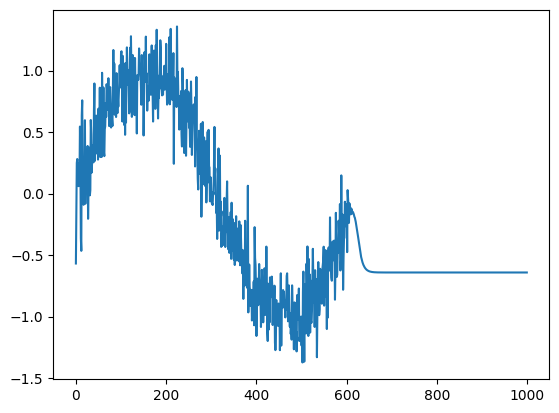

In [42]:
plt.plot(multistep_preds.detach().numpy())
##这个地方出错是正常的

In [43]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是第（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

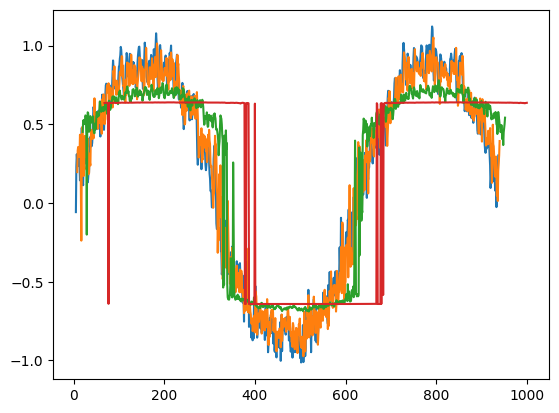

In [44]:
steps = (1, 4, 16, 64)
for i in steps:
    plt.plot(time[tau + i - 1: T - max_steps + i].detach().numpy(),
             features[:, (tau + i - 1)].detach().numpy())

In [45]:
import collections
import re
import requests
import matplotlib.pyplot as plt
import random 

In [46]:
def read_time_machine():
    DATA_HUB = dict()
    DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

    DATA_HUB['time_machine'] = ('http://d2l-data.s3-accelerate.amazonaws.com/'+ 'timemachine.txt',
                                    '090b5e7e70c295757f55df93cb0a180b9691891a')

    r = requests.get(DATA_HUB['time_machine'][0], stream=True, verify=True)

    f=open('../data/time_machine.txt', 'wb')
    f.write(r.content)
    f.close()

    with open('../data/time_machine.txt', 'r',encoding='utf-8') as f:
        lines=f.readlines()
        result=[re.sub('[^A-Za-z]', ' ', line).strip().lower() for line in lines]
    return result

# 词元化

In [47]:
def tokenize(text,token='word'):
    if token == 'word':
        return [i.split() for i in text]
    if token == 'char':
        return [list(line) for line in text]
    else:
        print('wrong token')

def count_corpus(tokens):
    '''统计词元频率'''
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

## 词表
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        self.tokens=tokens
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0,如果有其他的特殊标记词 则unk放在其他词前面
        self.idx_to_token = ['<unk>'] + reserved_tokens
        # 整理标记词的token to idx
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        
        # 整理所有满足条件的词
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
        
    def __len__(self):
        return len(self.token_to_idx)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
                return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs
    
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [48]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(174735, 28)

In [49]:
lines=read_time_machine()
tokens = tokenize(lines, 'word')

In [50]:
corpus = [token for line in tokens for token in line]
vocab = Vocab(tokens)

In [51]:
freq1=[j for i,j in vocab.token_freqs]

In [52]:
###二元词
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs
freq2=[j for i,j in bigram_vocab.token_freqs]

In [53]:
###三元词
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

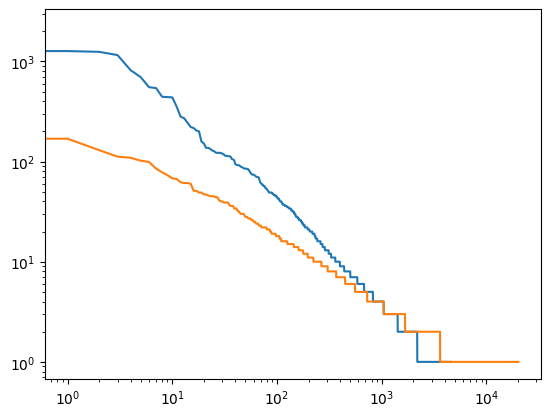

In [54]:
plt.plot(freq1)
plt.plot(freq2)
plt.xscale('log')
plt.yscale('log')
plt.show()
##在log上是线性 则82法则

下面的代码每次可以从数据中随机生成一个小批量。 在这里，参数batch_size指定了每个小批量中子序列样本的数目， 参数num_steps是每个子序列中预定义的时间步数。

In [55]:
def seq_data_iter_random(corpus,batch_size,num_steps):
    """使用随机抽样生成一个小批量子序列"""
    ## 随机一个初始位置 对序列分区，随即范围<=num_steps
    corpus=corpus[random.randint(0,num_steps-1):]
    ## 能够分出的子序列个数
    num_subseqs=(len(corpus)-1)//num_steps
    ## 每一个长度为子序列起始索引
    initial_indices=list(range(0,num_subseqs*num_steps,num_steps))
    ## 打乱
    random.shuffle(initial_indices)
    # 
    # def data(pos):
    #     return corpus[pos,pos+num_steps]
    
    num_batches=num_subseqs//batch_size
    for i in range(0,num_batches*batch_size,batch_size):
        initial_indices_per_batch=initial_indices[i:i+batch_size]
        x=[corpus[i:i+num_steps] for i in initial_indices_per_batch]
        y=[corpus[i+1:i+1+num_steps] for i in initial_indices_per_batch]
        yield torch.tensor(x),torch.tensor(y)
        


In [56]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[14, 15, 16, 17, 18],
        [ 9, 10, 11, 12, 13]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [10, 11, 12, 13, 14]])
X:  tensor([[19, 20, 21, 22, 23],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[20, 21, 22, 23, 24],
        [30, 31, 32, 33, 34]])
X:  tensor([[24, 25, 26, 27, 28],
        [ 4,  5,  6,  7,  8]]) 
Y: tensor([[25, 26, 27, 28, 29],
        [ 5,  6,  7,  8,  9]])


## 顺序分区

In [57]:
def seq_data_iter_sequential(corpus,batch_size,num_steps):
    offset=random.randint(0,num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    ## 把x展平 按照batch_size 拆为按照batch_size行 
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    ## 然后把每个batchsize 按照num_steps 继续拆分
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [58]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn=seq_data_iter_random
        else:
            self.data_iter_fn=seq_data_iter_sequential
        self.corpus,self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size,self.num_steps = batch_size,num_steps
        
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [59]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [60]:
s=SeqDataLoader(batch_size=10,num_steps=5,use_random_iter=False,max_tokens=10000)

# 循环神经网络

In [120]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
import sys
sys.path.append('../')
from utils.useful_func import *

batch_size, num_steps = 32, 35
##train_iter 返回的是每个字母的索引
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [62]:
## 将每个索引映射为相互不同的单位向量
F.one_hot(torch.tensor([2,3,4,5]),num_classes=10)
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28)

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [63]:
# 初始化模型参数
def get_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape,device=device)*0.01
    ## 隐藏层参数
    W_xh=normal((num_inputs,num_hiddens))
    W_hh=normal((num_hiddens,num_hiddens))
    b_h=torch.zeros(num_hiddens,device=device)
    W_hq=normal((num_hiddens,num_outputs))
    b_q=torch.zeros(num_outputs,device=device)
    params=[W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [64]:
def init_rnn_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size, num_hiddens),device=device))

In [65]:
def rnn(inputs, state,params):
    [W_xh,W_hh,b_h,W_hq,b_q]=params
    H=state
    outputs=[]
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0),(H)

In [66]:
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device,
                    get_params,init_state,forward_fn
                 ):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size,num_hiddens,device)
        self.init_state, self.forward_fn = init_state,forward_fn

    def __call__(self, inputs, state):
        X=F.one_hot(inputs.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state,self.params)
    
    def begin_state(self, batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)
    

In [67]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [68]:
F.one_hot(X.T, 28)

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [69]:
net = RNNModelScratch(len(vocab), 512, 'cpu', get_params,init_rnn_state, rnn)

In [70]:
state = net.begin_state(X.shape[0], 'cpu')

In [71]:
Y, new_state = net(X, state)

In [72]:
#输出形状是（时间步数批量大小，词表大小）， 而隐状态形状保持不变，即（批量大小，隐藏单元数）。
Y.shape,new_state.shape

(torch.Size([10, 28]), torch.Size([2, 512]))

In [74]:
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    norm=torch.sqrt(torch.sum(torch.tensor([torch.sum(p.grad**2) for p in net.parameters()])))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [ ]:
def train_epoch_ch8(net,)

In [125]:
use_random_iter=False

In [121]:
state,timer=None,Timer()
metric = Accumulator(2)

In [123]:
for X, Y in train_iter:
    if state is None or use_random_iter:
        # 在第一次迭代或使用随机抽样时初始化state
        state = net.begin_state(batch_size=X.shape[0], device=device)
    else:
        if isinstance(net, nn.Module) and not isinstance(state, tuple):
            # state对于nn.GRU是个张量
            state.detach_()
        else:
            # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
            for s in state:
                s.detach_()

In [124]:
train_iter